In [1]:
!pip install shap


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import requests

from sklearn.model_selection import train_test_split

# import some learn-to-rank method
import pandas as pd
import lightgbm as lgb

import shap
from sharp.utils import scores_to_ordering

# utility functions
from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(42, **{"font.family":"Times"})

Could not find a LaTeX installation. ``text.usetex`` will be set to False.


In [3]:
from IPython.display import Image
from IPython.core.display import HTML

shap.initjs()

# Define functions

In [4]:
# def calculate_relevance(ranks):
#     """Converts a rank vector to a relevance score"""
#     relevance_scores = 1 - ranks / ranks.shape[0]
#     return relevance_scores

# data
We use the "movers" data from
Yang, Ke, Joshua R. Loftus, and Julia Stoyanovich. "Causal intersectionality for fair ranking." arXiv preprint arXiv:2006.08688 (2020).

In [5]:
def file_formatting(df):
    df['qid'] = df['qid'].str.replace('qid:', '')
    df['gender'] = df['gender'].str.replace('1:', '')
    df['race'] = df['race'].str.replace('2:', '')
    df['X'] = df['X'].str.replace('3:', '')
    df['Y'] = df['Y'].str.replace('4:', '')
    df = df.astype({'gender': int, 'race': int, 'X': float, 'Y': float})
    print(df.describe())
    return df

def process_file(directory, filenum):
    url="http://raw.githubusercontent.com/DataResponsibly/CIFRank/master/out/ranklib_data/mv/m2/Full"
    file_test = url+'/'+directory+'/'+filenum+'_test_ranklib.txt'
    file_train = url+'/'+directory+'/'+filenum+'_train_ranklib.txt'
    s=requests.get(file_train).content
    df_train = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])
    s=requests.get(file_test).content
    df_test = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])
    print(df_test)
    train_df = file_formatting(df_train)
    validation_df = file_formatting(df_test)

    qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
    # Create ranking as the "relevance" score
    X_train = train_df.sort_values('Y', ascending=False)
    n_rows = X_train.shape[0]
    X_train['rank'] = range(1, n_rows + 1)
    # Assign outcome
    y_train = X_train["rank"]
    # Drop columns we don't use
    X_train = X_train.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

    qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
    # Create ranking as the "relevance" score
    X_validation = validation_df.sort_values('Y', ascending=False)
    n_rows = X_validation.shape[0]
    X_validation['rank'] = range(1, n_rows + 1)
    # Assign outcome
    y_validation = X_validation["rank"]
    # Drop columns we don't use
    X_validation = X_validation.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

    return X_train, y_train, X_validation, y_validation, qids_train, qids_validation

# Training

In [6]:
def train_model(X_train, y_train, X_validation, y_validation, qids_train, qids_validation):
    model = lgb.LGBMRanker(
        objective="lambdarank",
        # metric="ndcg",
        # min_data_in_leaf=1,
        label_gain=list(range(max(y_train.values)+1)),# np.unique(y_train.values)
        #verbose=-1
    )
    model.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set=[(X_validation, y_validation)],
        eval_group=[qids_validation],
        eval_at=10,
    )
    return model

In [46]:
def run_shap(model, X_train, X_validation, directory, filename):
    # xai = ShaRP(
    #     qoi="ranking",
    #     target_function=model.predict,
    #     measure="shapley",
    #     sample_size=3, # sample_size=None,
    #     replace=False,
    #     random_state=42,
    #     verbose=1,
    #     n_jobs=-1
    # )
    # xai.fit(X_train)
    #
    # shapley_values = pd.DataFrame(
    #     xai.all(X_validation),
    #     columns=X_validation.columns,
    #     index=X_validation.index
    # )
    # shapley_values["score"] = model.predict(X_validation)
    # shapley_values["ranking"] = scores_to_ordering(shapley_values["score"])
    # shapley_values.to_csv(f"{directory}{filename}_test_ranklib_{xai.qoi_.__class__.__name__.lower()}_shapley_values.csv")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_validation)
    # shap_values2 = explainer(X_train)

    # print(explainer.expected_value)
    # print(shap_values)
    # print(shap_values2)
    # shap.force_plot(explainer.expected_value, shap_values[12, :], X_train.iloc[12, :], matplotlib=True)
    # shap.plots.waterfall(shap_values2[12])
    # shap.summary_plot(shap_values, X_validation)
    shap_results = pd.DataFrame(shap_values, columns=X_validation.columns)
    shap_results["score"] = model.predict(X_validation)
    shap_results["ranking"] = scores_to_ordering(shap_results["score"])
    shap_results.to_csv(f"{directory}{filename}_test_ranklib_SHAP.csv")

    print()

In [47]:
def get_ftr_importance(directory, filename):
    X_train, y_train, X_validation, y_validation, qids_train, qids_validation = process_file(directory, filename)

    y_train[y_train != 0] = scores_to_ordering(y_train[y_train != 0], direction=1)
    y_validation[y_validation != 0] = scores_to_ordering(y_validation[y_validation != 0], direction=1)

    model = train_model(X_train, y_train, X_validation, y_validation, qids_train, qids_validation)

    relevance = model.predict(X_train)
    print(relevance)

    print(scores_to_ordering(relevance, 1), y_train.values)

    run_shap(model, X_train, X_validation, directory, filename)



In [48]:
for directory in ['bias__bias', 'fair_count__bias', 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    for file in ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10']:
        get_ftr_importance(directory,file)

      relevance    qid gender race                       X  \
0           405  qid:2    1:0  2:0    3:0.8905622391104341   
1             0  qid:2    1:1  2:0   3:-0.9931882439439548   
2            37  qid:2    1:1  2:0   3:0.09011347288247328   
3           103  qid:2    1:0  2:0    3:0.4180103275216323   
4           453  qid:2    1:0  2:1     3:1.040016112790311   
...         ...    ...    ...  ...                     ...   
1995          0  qid:2    1:0  2:0  3:-0.17278963317592605   
1996          0  qid:2    1:1  2:0   3:-1.5129578818281837   
1997          0  qid:2    1:0  2:1   3:-1.2283299489046031   
1998        407  qid:2    1:1  2:0    3:0.8489404066149615   
1999          0  qid:2    1:1  2:1   3:-1.8938322893004933   

                          Y                         meta  
0       4:0.829342975896658  #docid=993;rel=405;g=M;r=W;  
1     4:-0.7685317175339498   #docid=1831;rel=0;g=F;r=W;  
2     4:0.21127352680867026  #docid=1397;rel=37;g=F;r=W;  
3      4:0.28836494

# Make plots

In [49]:
shapley_all = pd.DataFrame()
for directory in ['bias__bias', 'fair_count__bias', 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    #for file in ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10']:
    for file in ['R10']:
        buckets = 10
        shapley_values = pd.read_csv(f"{directory}{file}_test_ranklib_SHAP.csv", index_col="Unnamed: 0").rename(columns={"X":"qualification"})


        shapley_values['rank_bucket'] = [
            (
                str(math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) * 10)
                + "-\n"
                + str(math.floor(((rank - 1) / (shapley_values.shape[0] / buckets)) + 1) * 10)
                + "%"
            )
            if math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) != 0
            else "<10%"
            for rank in shapley_values['ranking']
        ]

        shapley_values["Rank Bucket"] = shapley_values["rank_bucket"].str.replace("%", r"\%").str.replace("<", "$<$")
        shapley_values = (
            shapley_values
            .drop(columns=["rank_bucket", "ranking", "score"])
            .melt(id_vars=["Rank Bucket"])
            .rename(columns={"variable": "Feature", "value": "Contribution"})
        )

        shapley_values.sort_values(["Rank Bucket", "Feature"], inplace=True)
        shapley_values["type"] = directory
        shapley_values["experiment"] = file
        shapley_all = pd.concat([shapley_values, shapley_all])

In [50]:
shapley_all

,Rank Bucket,Feature,Contribution,type,experiment
1763,$<$10\%,gender,-0.041738,fair_res__fair_res,R10
1772,$<$10\%,gender,-0.041738,fair_res__fair_res,R10
1774,$<$10\%,gender,-0.041738,fair_res__fair_res,R10
1775,$<$10\%,gender,-0.041738,fair_res__fair_res,R10
1781,$<$10\%,gender,-0.041738,fair_res__fair_res,R10
...,...,...,...,...,...
2983,90-\n100\%,race,-0.112604,bias__bias,R10
2992,90-\n100\%,race,-0.113369,bias__bias,R10
2993,90-\n100\%,race,-0.112604,bias__bias,R10
3014,90-\n100\%,race,-0.112602,bias__bias,R10


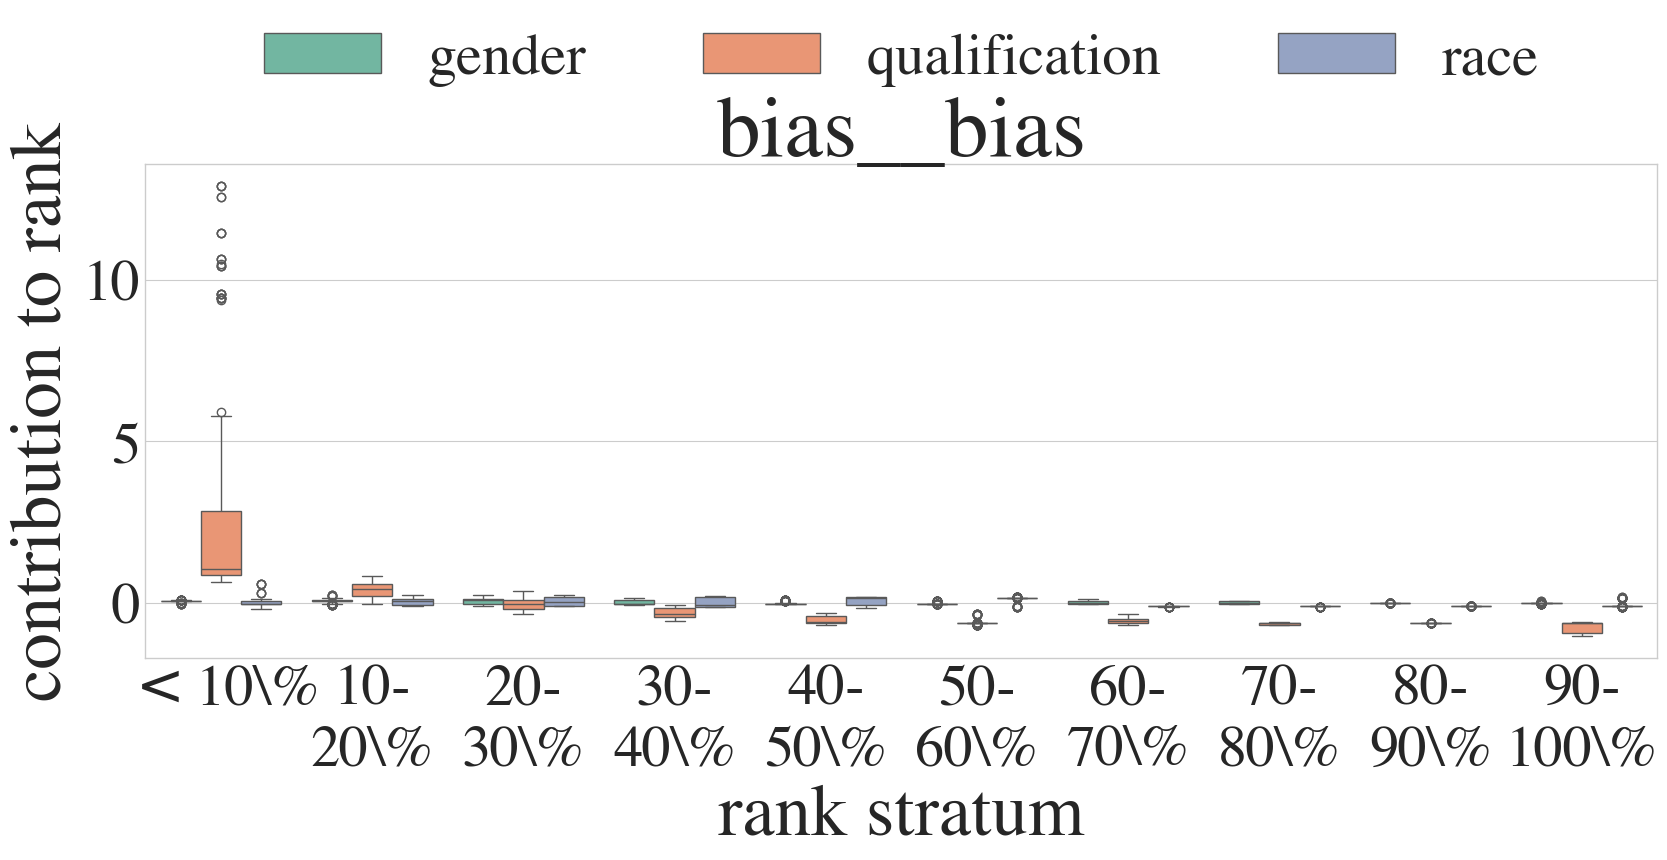

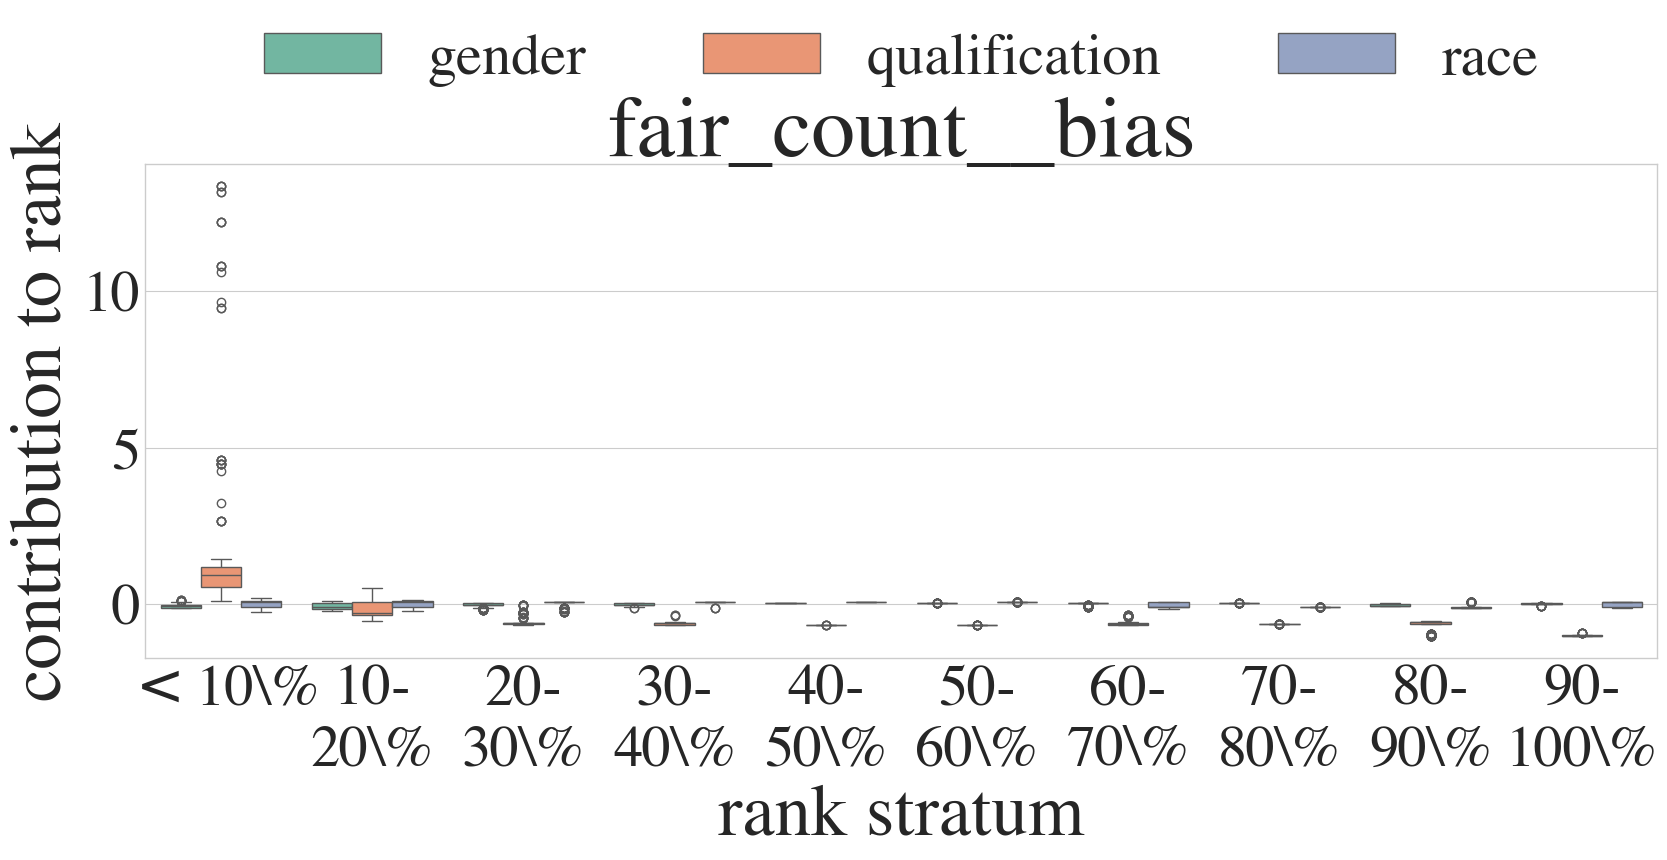

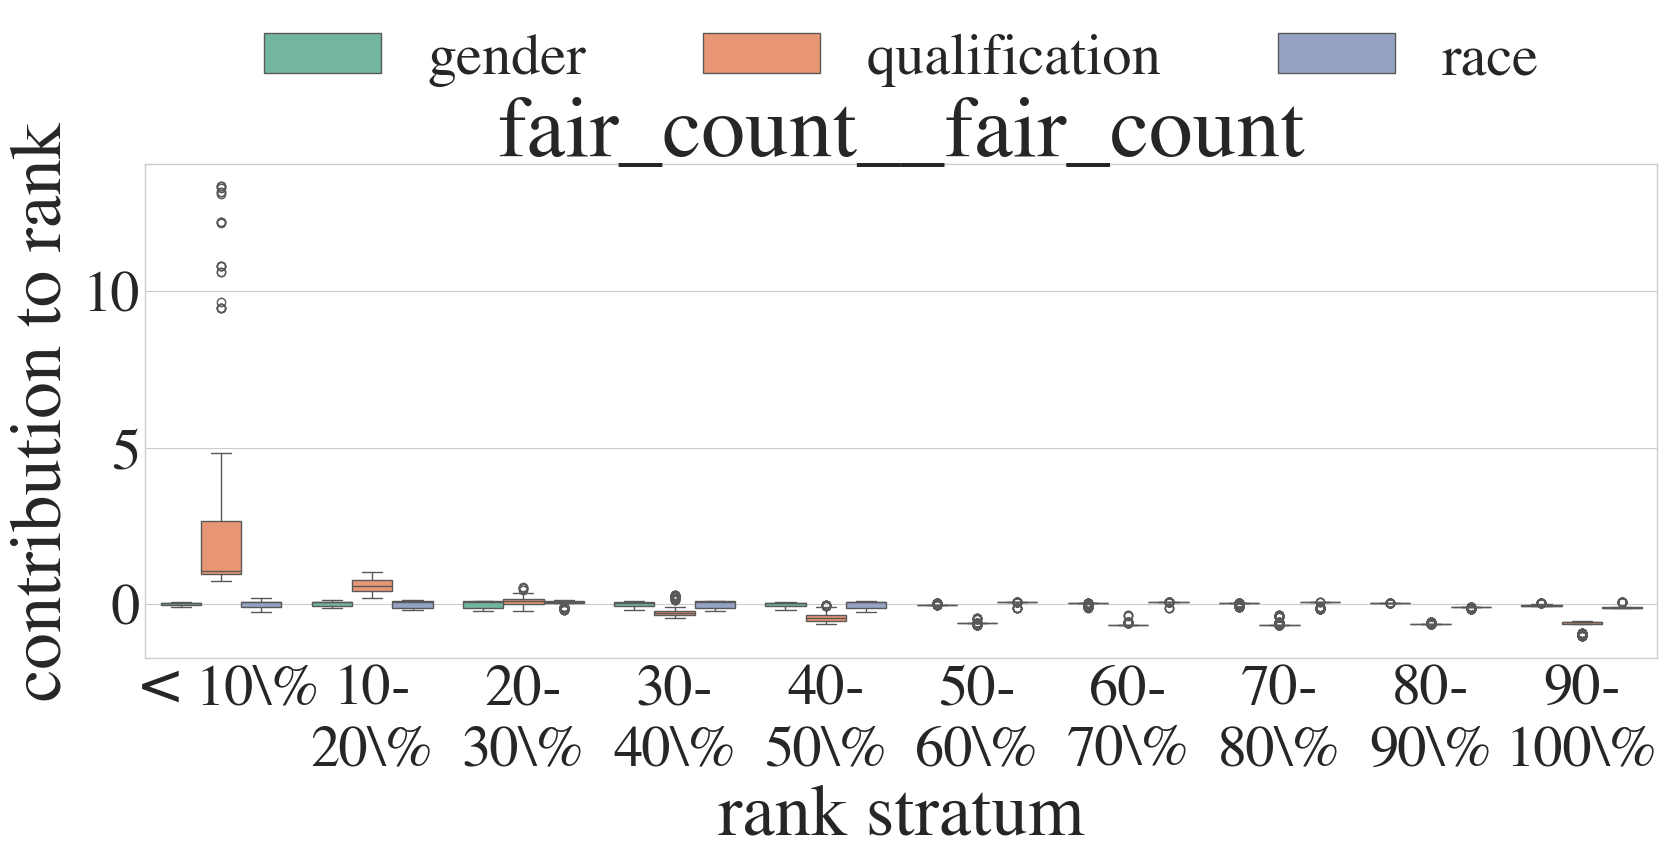

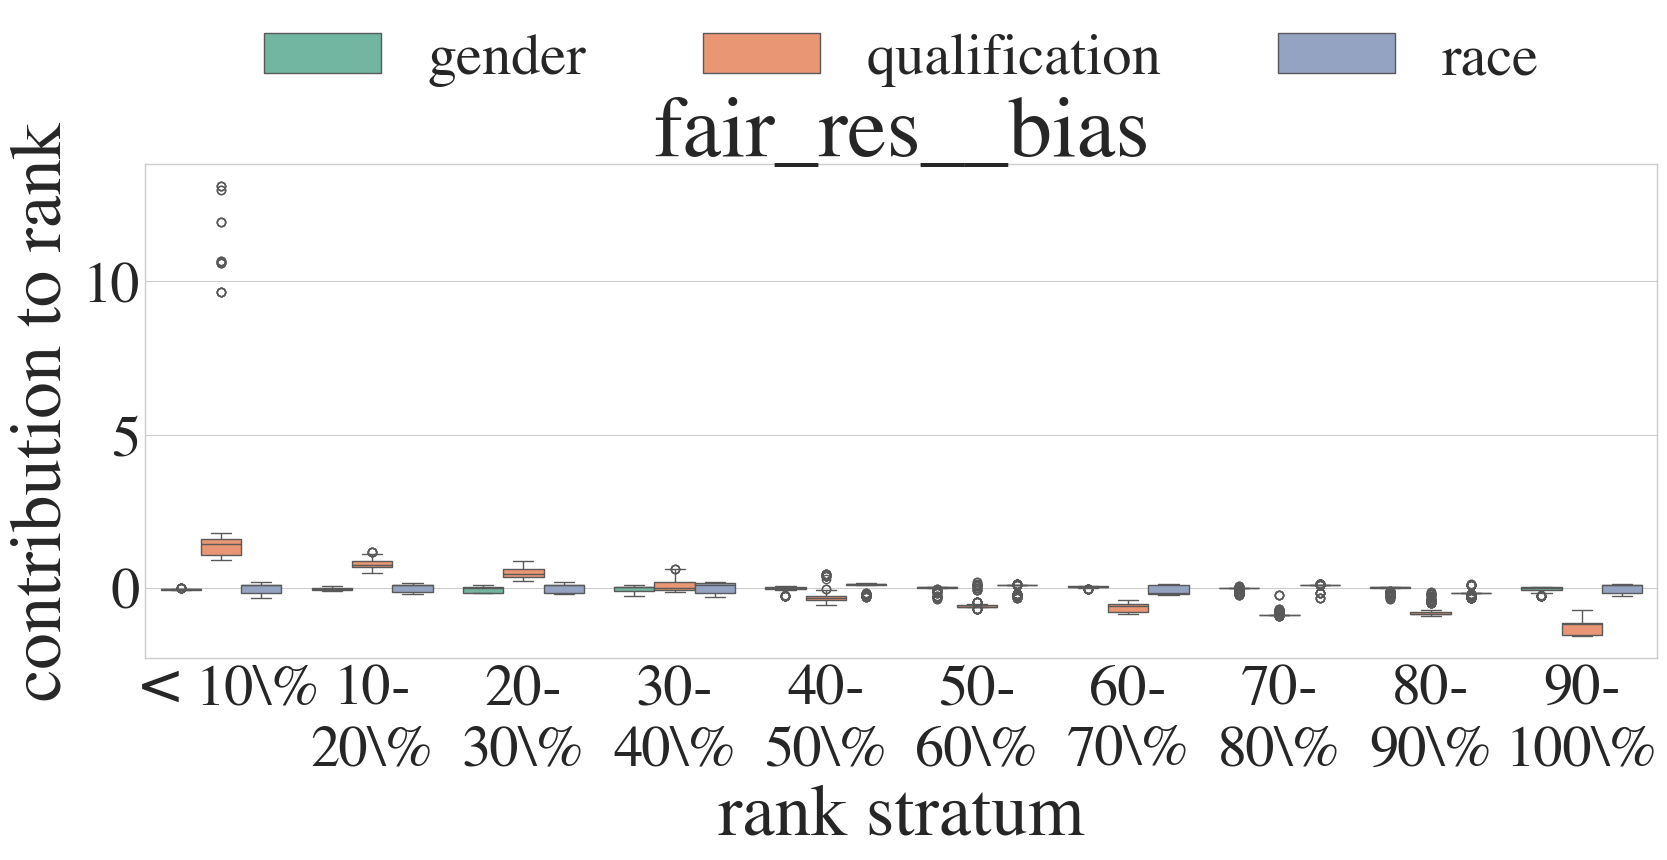

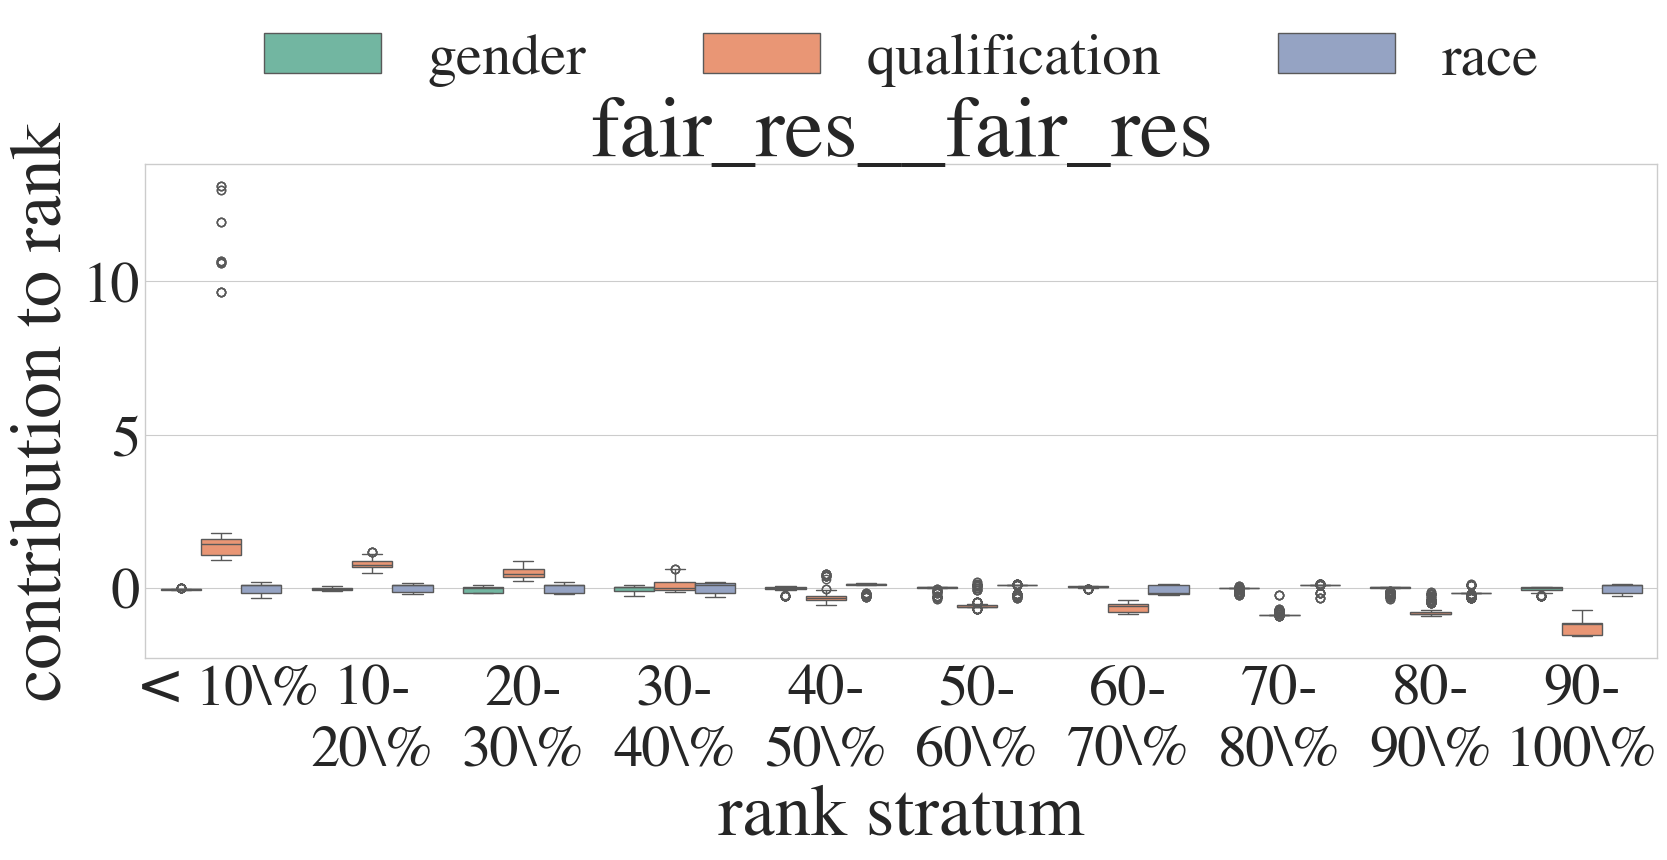

In [51]:
for directory in ['bias__bias', 'fair_count__bias', 'fair_count__fair_count', 'fair_res__bias', 'fair_res__fair_res']:
    shapley_values = shapley_all[shapley_all["type"] == directory]
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
    graph = sns.boxplot(
        x=shapley_values['Rank Bucket'],
        y=shapley_values['Contribution'],
        hue=shapley_values['Feature'],
        palette="Set2"
    )
    graph.set_ylabel("contribution to rank")
    graph.set_xlabel("rank stratum")
    sns.move_legend(
        graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
    )

    plt.savefig(
        f"r10_contrs_rank.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.title(directory)
    plt.show()